MnistGPU.ipynb, but with guidance. This should make results more consistent and easier to recognize.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import diffusers
from tqdm import tqdm
from torchvision import transforms
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from diffusers import UNet2DModel, DDPMScheduler

import datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image

c:\Mine\Master\MyNca\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [3]:
mnist_dataset = datasets.load_dataset('mnist', split='train')

In [4]:
#Testing without labels 4 and 6 
excluded_labels = {4, 6}

filtered_dataset = mnist_dataset.filter(lambda example: example['label'] not in excluded_labels)
filtered_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 48240
})

In [5]:
# the current dataset is a hugging face dataset, which stores samples as dictionaries
# But the guide i am following uses pytorch datasets in which data is stored as pairs

# Define a PyTorch Dataset class
class MNISTDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']

        # Convert PIL image to NumPy array
        if isinstance(image, Image.Image):  
            image = np.array(image)  # Convert to NumPy

        # Convert NumPy array to PyTorch tensor and normalize
        image = torch.tensor(image, dtype=torch.float32) / 255.0  # Normalize to [0,1]
        image = image.unsqueeze(0)  # Add channel dimension -> [1, 28, 28]
        
        # Convert label to a tensor
        label = torch.tensor(item['label'], dtype=torch.long)
        
        return image, label

# Wrap the dataset
pytorch_dataset = MNISTDataset(filtered_dataset)

Input shape: torch.Size([128, 1, 28, 28])
Labels: tensor([0, 8, 2, 8, 7, 5, 8, 9, 8, 5, 8, 8, 9, 3, 7, 7, 1, 5, 8, 7, 8, 9, 1, 2,
        5, 2, 5, 5, 0, 3, 3, 0, 5, 5, 5, 0, 5, 9, 1, 7, 1, 7, 7, 3, 3, 7, 1, 3,
        1, 5, 8, 5, 3, 2, 7, 9, 3, 2, 9, 5, 0, 1, 3, 3, 9, 9, 9, 9, 9, 5, 8, 3,
        1, 9, 3, 0, 7, 0, 3, 1, 0, 1, 9, 5, 0, 5, 1, 1, 8, 7, 8, 5, 5, 9, 5, 3,
        8, 9, 1, 0, 5, 0, 8, 9, 2, 1, 1, 9, 3, 1, 1, 1, 8, 9, 8, 5, 5, 5, 8, 3,
        0, 8, 0, 9, 3, 9, 7, 7])


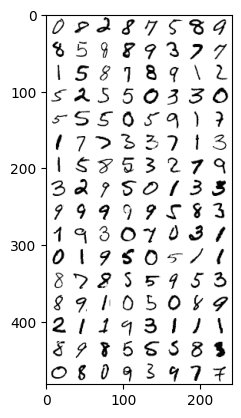

In [6]:
# Create DataLoader
train_dataloader = DataLoader(pytorch_dataset, batch_size=128, shuffle=True)

# View some examples
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)  # Should be [batch_size, 1, 28, 28]
print('Labels:', y)

# Visualize images
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

In [7]:
#Try changing class embedding to instead use one hot encoded
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()
    
    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)


    self.guidance_prob=0.1

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 128, 128), 
        down_block_types=( 
            "DownBlock2D",        # a regular ResNet downsampling block
            "DownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ), 
        up_block_types=(
            "AttnUpBlock2D", 
            "UpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape
    
    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    batch_size, embed_dim = class_cond.shape
    mask = torch.rand(batch_size, device=class_cond.device) < self.guidance_prob
    class_cond[mask] = torch.zeros(embed_dim, device=class_cond.device)
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)
    
    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [8]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=200, beta_schedule='squaredcos_cap_v2')

100%|██████████| 377/377 [00:46<00:00,  8.03it/s]


Finished epoch 0. Average of the last 100 loss values: 0.083517


100%|██████████| 377/377 [00:46<00:00,  8.13it/s]


Finished epoch 1. Average of the last 100 loss values: 0.061424


100%|██████████| 377/377 [00:46<00:00,  8.13it/s]


Finished epoch 2. Average of the last 100 loss values: 0.055605


100%|██████████| 377/377 [00:46<00:00,  8.12it/s]


Finished epoch 3. Average of the last 100 loss values: 0.051067


100%|██████████| 377/377 [00:46<00:00,  8.10it/s]


Finished epoch 4. Average of the last 100 loss values: 0.048776


100%|██████████| 377/377 [00:46<00:00,  8.07it/s]


Finished epoch 5. Average of the last 100 loss values: 0.047616


100%|██████████| 377/377 [00:46<00:00,  8.11it/s]


Finished epoch 6. Average of the last 100 loss values: 0.045568


100%|██████████| 377/377 [00:46<00:00,  8.11it/s]


Finished epoch 7. Average of the last 100 loss values: 0.044747


100%|██████████| 377/377 [00:46<00:00,  8.10it/s]


Finished epoch 8. Average of the last 100 loss values: 0.044126


100%|██████████| 377/377 [00:46<00:00,  8.12it/s]

Finished epoch 9. Average of the last 100 loss values: 0.043015


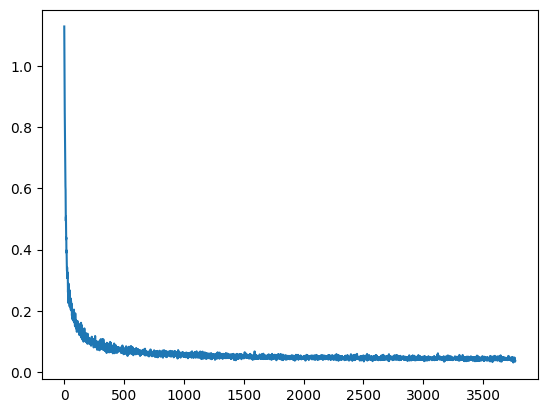

In [9]:
n_epochs = 10

# Our network 
net = ClassConditionedUnet().to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-4) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for image, label in tqdm(train_dataloader):
        
        # Get some data and prepare the corrupted version
        image = image.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        label = label.to(device)
        noise = torch.randn_like(image)
        timesteps = torch.randint(0, 199, (image.shape[0],)).long().to(device)
        noisy_image = noise_scheduler.add_noise(image, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_image, timesteps, label) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

200it [00:10, 19.78it/s]


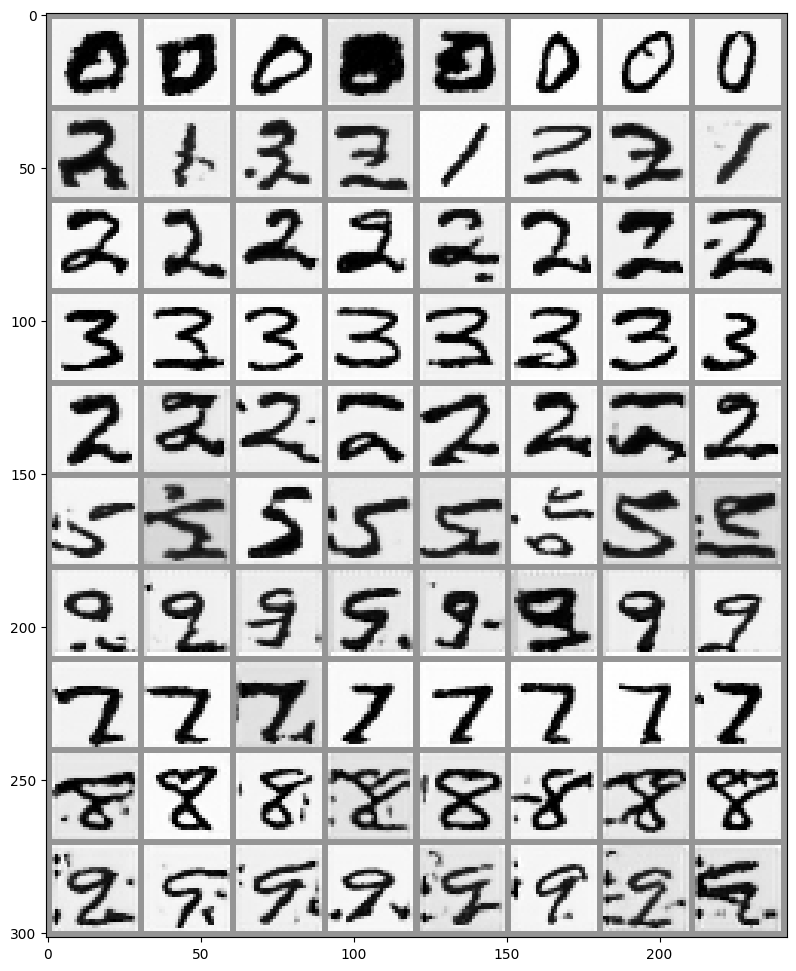

In [11]:

x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)
y_uncond = torch.zeros_like(y) # unconditional samples
noise_scheduler.set_timesteps(200)

guidance_scale = 7.5

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        # Get unconditioned and conditioned predictions
        residual_uncond = net(x, t, y_uncond)  # Without conditioning
        residual_cond = net(x, t, y)           # With conditioning
        
        # Apply CFG: interpolate between uncond & cond
        residual = residual_uncond + guidance_scale * (residual_cond - residual_uncond)

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')